## Final Project for KSE624 Mobile and Pervasive Computing for Knowledge Services Spring 2020 at KAIST
<br>
Last Updated Date: July 01 2020 <br>
Authors: <br>
    &emsp;Rafikatiwi Nur Pujiarti <br>
    &emsp;Willmer R. Quinones <br>
<br>


### Model Evaluation

In [2]:
## Necessary Packages
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from PIL import Image
from itertools import islice

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [3]:
def get_indices(n, k, indices):

    '''

    Dividing the indices of the data into k folds

    Args:
        - n: (int) number of datapoints
        - k: (int) number of folds
        - indices: (numpy.array) indices of the dataset
    Returns:
        yields 1-fold from the indices

    '''

    fold_sizes = np.ones(k) * int(n/k)
    fold_sizes[0:(n % k)] += 1
    current = 0
    for fold_size in fold_sizes:
        start = current
        stop =  current + fold_size
        current = stop
        yield(indices[int(start):int(stop)])

In [4]:
def k_folds(n, k):

    '''

    Dividing the dataset into training / validation set and into k-folds

    Args:
        - n: (int) number of datapoints
        - k: (int) number of folds
    Returns:
        yields 1-fold from the training / validation sets

    '''

    indices = np.arange(n).astype(int)
    np.random.shuffle(indices)
    for test_idx in get_indices(n, k, indices):
        train_idx = np.setdiff1d(indices, test_idx)
        yield train_idx, test_idx

In [5]:
def train(dataloaders, model, epoch, optimizer, criterion, device):

    '''

    Training and validating the model

    Args:
        - dataloaders: (dict) Training and validation dataset
        - model: (torch.nn.Module / torchvision.models) Neural Network model
        - epoch: (int) current epoch
        - optimizer: (torch.optim) optimizer
        - criterion: (torch.nn) loss function
        - device: (torch.device) either cpu or gpu (cuda)
    Returns:
        - train_loss: (float) training loss
        - val_loss: (float) validation loss
        - train_acc: (float) training accuracy
        - val_acc: (val_acc) validation accuracy

    '''

    since = time.time()    
    # # Training   
    model.train()
    running_loss, running_corrects = 0, 0
    enumerator = enumerate(dataloaders['train'])    
    for idx, (inputs, labels) in enumerator:
        X = inputs.to(device)
        labels = labels.long().to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X)
        _, preds = outputs.data.max(1)
        
        loss = criterion(outputs, labels)
        loss.backward()  

        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        
    train_loss = running_loss/len(dataloaders['train'].dataset)
    train_acc = running_corrects/len(dataloaders['train'].dataset)
    
    # # Validating
    model.eval()
    running_loss, running_corrects = 0, 0
    enumerator = enumerate(dataloaders['val'])  
    for idx, (inputs, labels) in enumerator:
        X = inputs.to(device)
        labels = labels.long().to(device)
        
        outputs = model(X)
        _, preds = outputs.data.max(1)
        
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        
    val_loss = running_loss/len(dataloaders['val'].dataset)
    val_acc = running_corrects/len(dataloaders['val'].dataset)
    
    epoch_time = (time.time() - since)/60
    print(f'{epoch}\t Epoch Time: {epoch_time:.2f}mins\t Loss: {val_loss:.2f}\t Acc: {val_acc:.2f}')
    return (train_loss, val_loss, train_acc, val_acc)

In [6]:
def test(dataloader, model, classes, criterion, device):

    '''

    Testing the model. It also prints a confusion matrix

    Args:
        - dataloaders: (torch.utils.data.Dataloader) Testing dataset
        - model: (torch.nn.Module / torchvision.models) Neural Network model
        - classes: (list) names of the classes
        - criterion: (torch.nn) loss function
        - device: (torch.device) either cpu or gpu (cuda)
    Returns:
        - test_loss: (float) Testing loss
        - test_acc: (float) Testing accuracy

    '''

    model.eval()
    
    running_loss, running_corrects = 0, 0

    real_values = []
    pred_values = []

    enumerator = enumerate(dataloader)  
    for idx, (inputs, labels) in enumerator:
        X = inputs.to(device)
        labels = labels.to(device)

        outputs = model(X)
        _, preds = outputs.data.max(1)

        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

        real_values += labels.detach().cpu().tolist()
        pred_values += preds.detach().cpu().tolist()

    test_loss = running_loss/len(dataloader.dataset)
    test_acc = running_corrects/len(dataloader.dataset)

    real_values = np.array(real_values)
    pred_values = np.array(pred_values)

    print(f'Loss: {test_loss:.2f}\t Acc: {test_acc * 100:.2f}%\n')
    cm = confusion_matrix(real_values, pred_values)
    cm_df = pd.DataFrame(cm, columns = classes, index = classes)
    print(cm_df)
    print()

    return (test_loss, test_acc)

In [7]:
# # Pipeline
train_folder = 'dataset/train'     # Training set
test_folder = 'dataset/test'       # Testing set
resize_size = 100                # Resize the input images
batch_size = 32
epochs = 30
k = 10
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [8]:
# Load and transform the datasets
trans_params = transforms.Compose([
           transforms.Resize((resize_size, resize_size)),    
           transforms.Grayscale(num_output_channels = 3),
           transforms.ToTensor(),
           transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(train_folder, trans_params)

test_dataset = ImageFolder(test_folder, trans_params)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size,
                                   num_workers = 4, shuffle = False)

num_classes = len(train_dataset.class_to_idx)
classes = [c for c in train_dataset.class_to_idx.keys()]

In [9]:
'''
To perform cross-validation, we have to extract the labels and data from
Dataset so it can be divided into k-folds
'''
y_train = np.array([y for x, y in iter(train_dataset)])
y_train = torch.from_numpy(y_train).float()
x_train = np.array([np.array(x) for x, y in iter(train_dataset)])
x_train = torch.from_numpy(x_train).float()

In [10]:
dataloaders = {}
fold_val_acc = {}
fold_val_loss = {}
fold_train_acc = {}
fold_train_loss = {}
fold_test_acc = {}
fold_test_loss = {}
count = 0

# Cross-validation
for train_idx, val_idx in k_folds(len(y_train), k):  
    print(f'<=========== {count + 1}-fold out of {k}-folds ===========>')
    # Data Loaders
    dataset_train = TensorDataset(x_train[train_idx], y_train[train_idx])
    dataset_val = TensorDataset(x_train[val_idx], y_train[val_idx])
    dataloaders['train'] = DataLoader(dataset_train, batch_size = batch_size,
                                      num_workers = 4, shuffle = True)
    dataloaders['val'] = DataLoader(dataset_val, batch_size = batch_size,
                                   num_workers = 4, shuffle = False)
    fold_val_acc[count] = []
    fold_val_loss[count] = []
    fold_train_acc[count] = []
    fold_train_loss[count] = []
    fold_test_acc[count] = []
    fold_test_loss[count] = []

    # Model definition
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(in_features = 2048, out_features = num_classes)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), 1e-3)
    criterion = nn.CrossEntropyLoss()

    # Training the model
    for epoch in range(epochs):
        train_loss, val_loss, train_acc, val_acc = train(dataloaders, model, epoch, optimizer, criterion, device)
        fold_train_acc[count].append(train_acc)
        fold_train_loss[count].append(train_loss)
        fold_val_acc[count].append(val_acc)
        fold_val_loss[count].append(val_loss)

    # Testing the model
    print()
    test_loss, test_acc = test(test_dataloader, model, classes, criterion, device)
    fold_test_acc[count].append(test_acc)
    fold_test_loss[count].append(test_loss)
    count += 1
    print()
    print()

<=========== 1-fold out of 10-folds ===========>
0	 Epoch Time: 0.42mins	 Loss: 0.61	 Acc: 0.75
1	 Epoch Time: 0.41mins	 Loss: 0.64	 Acc: 0.74
2	 Epoch Time: 0.36mins	 Loss: 0.79	 Acc: 0.77
3	 Epoch Time: 0.39mins	 Loss: 0.55	 Acc: 0.82
4	 Epoch Time: 0.38mins	 Loss: 0.77	 Acc: 0.76
5	 Epoch Time: 0.41mins	 Loss: 0.59	 Acc: 0.80
6	 Epoch Time: 0.56mins	 Loss: 0.95	 Acc: 0.74
7	 Epoch Time: 0.41mins	 Loss: 0.78	 Acc: 0.76
8	 Epoch Time: 0.46mins	 Loss: 0.48	 Acc: 0.83
9	 Epoch Time: 0.41mins	 Loss: 0.45	 Acc: 0.86
10	 Epoch Time: 0.40mins	 Loss: 0.66	 Acc: 0.81
11	 Epoch Time: 0.40mins	 Loss: 0.68	 Acc: 0.83
12	 Epoch Time: 0.40mins	 Loss: 0.71	 Acc: 0.81
13	 Epoch Time: 0.39mins	 Loss: 0.83	 Acc: 0.79
14	 Epoch Time: 0.39mins	 Loss: 0.79	 Acc: 0.78
15	 Epoch Time: 0.39mins	 Loss: 0.65	 Acc: 0.82
16	 Epoch Time: 0.40mins	 Loss: 0.81	 Acc: 0.81
17	 Epoch Time: 0.40mins	 Loss: 0.93	 Acc: 0.79
18	 Epoch Time: 0.39mins	 Loss: 0.58	 Acc: 0.86
19	 Epoch Time: 0.44mins	 Loss: 0.65	 Acc: 0.86
2

10	 Epoch Time: 0.48mins	 Loss: 0.67	 Acc: 0.83
11	 Epoch Time: 0.48mins	 Loss: 1.09	 Acc: 0.78
12	 Epoch Time: 0.47mins	 Loss: 0.80	 Acc: 0.82
13	 Epoch Time: 0.50mins	 Loss: 0.81	 Acc: 0.78
14	 Epoch Time: 0.44mins	 Loss: 1.05	 Acc: 0.75
15	 Epoch Time: 0.44mins	 Loss: 0.96	 Acc: 0.79
16	 Epoch Time: 0.54mins	 Loss: 1.45	 Acc: 0.72
17	 Epoch Time: 0.53mins	 Loss: 0.71	 Acc: 0.80
18	 Epoch Time: 0.47mins	 Loss: 0.90	 Acc: 0.76
19	 Epoch Time: 0.41mins	 Loss: 0.71	 Acc: 0.83
20	 Epoch Time: 0.44mins	 Loss: 0.97	 Acc: 0.79
21	 Epoch Time: 0.51mins	 Loss: 1.00	 Acc: 0.80
22	 Epoch Time: 0.45mins	 Loss: 0.67	 Acc: 0.83
23	 Epoch Time: 0.44mins	 Loss: 0.89	 Acc: 0.81
24	 Epoch Time: 0.45mins	 Loss: 0.94	 Acc: 0.79
25	 Epoch Time: 0.56mins	 Loss: 1.50	 Acc: 0.72
26	 Epoch Time: 0.58mins	 Loss: 1.17	 Acc: 0.75
27	 Epoch Time: 0.58mins	 Loss: 0.84	 Acc: 0.80
28	 Epoch Time: 0.56mins	 Loss: 0.90	 Acc: 0.79
29	 Epoch Time: 0.56mins	 Loss: 1.08	 Acc: 0.82

Loss: 0.83	 Acc: 83.40%

              

21	 Epoch Time: 0.46mins	 Loss: 0.58	 Acc: 0.84
22	 Epoch Time: 0.46mins	 Loss: 0.61	 Acc: 0.86
23	 Epoch Time: 0.44mins	 Loss: 1.34	 Acc: 0.75
24	 Epoch Time: 0.43mins	 Loss: 0.76	 Acc: 0.81
25	 Epoch Time: 0.43mins	 Loss: 0.84	 Acc: 0.80
26	 Epoch Time: 0.43mins	 Loss: 0.66	 Acc: 0.84
27	 Epoch Time: 0.43mins	 Loss: 0.62	 Acc: 0.84
28	 Epoch Time: 0.55mins	 Loss: 0.84	 Acc: 0.80
29	 Epoch Time: 0.53mins	 Loss: 0.53	 Acc: 0.84

Loss: 0.79	 Acc: 80.83%

               long pants  shirt  shorts  thick clothes  thin jacket
long pants             94      0       3              1            2
shirt                   1     73       4              9           13
shorts                  0      0      97              3            0
thick clothes           3      9       4             66           18
thin jacket             2     12       1             12           79



<=========== 10-fold out of 10-folds ===========>
0	 Epoch Time: 0.55mins	 Loss: 1.27	 Acc: 0.56
1	 Epoch Time: 0.53mins	 Los

In [17]:
# Handling the metrics
for count in range(k):
    fold_val_acc[count] = np.array(fold_val_acc[count])
    fold_val_loss[count] = np.array(fold_val_loss[count])
    fold_train_acc[count] = np.array(fold_train_acc[count])
    fold_train_loss[count] = np.array(fold_train_loss[count])
    fold_test_acc[count] = np.array(fold_test_acc[count])
    fold_test_loss[count] = np.array(fold_test_loss[count])
    
acc = []
last = []
for count in range(k):
    acc.append(fold_test_acc[count])
    last.append(fold_train_loss[count][-1])   


In [18]:
mean_acc = np.array(acc).mean()
std_acc = np.array(acc).std()

print(f'Avg. Acc: {mean_acc:.2f} +/- {std_acc:.2f}')

Avg. Acc: 0.81 +/- 0.03


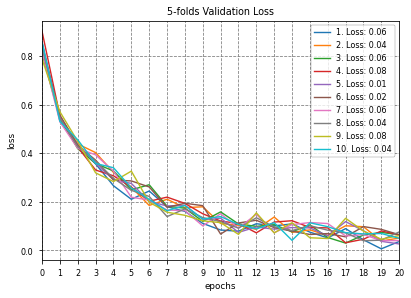

In [19]:
plt.style.use('seaborn-paper')
fig, ax = plt.subplots()

for i in range(k):
    ax.plot(fold_train_loss[i])

last_losses = [f'{i}. Loss: {l:.2f}' for i, l in zip(range(1, k + 1), last)]
ax.legend(last_losses, facecolor='white', edgecolor = 'black', frameon=True)

ax.grid(True)
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('5-folds Validation Loss')
ax.set_xlim([0,20])
#ax.grid(False)
ax.grid(color='gray', linestyle='--')
ax.set_facecolor('white')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
#plt.savefig('evaluation-plots.png', bbox_inches='tight')
plt.show()